Name: Nishit Shaileshbhai Rathod     
Student No: N01586439

# Tabular regression with Amazon SageMaker LightGBM algorithm.

This notebook demonstrates the use of Amazon SageMaker's implementation of LightGBM algorithm to train and host a tabular regression model. Tabular regression is the task of analyzing the relationship between predictor variables and a response variable in a structured or relational data.

In this notebook, we demonstrate two use cases of tabular regression models:

- How to train a tabular model on an example dataset to do regression.
- How to use the trained tabular model to perform inference, i.e., predicting new samples.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

# Set Up

Before executing the notebook, there are some initial steps required for setup.

To train and host on Amazon SageMaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3.

In [5]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

# Train a Tabular Model on Abalone Dataset

In this demonstration, we will train a tabular algorithm on the University dataset. The dataset contains examples of 7 features and a target value.

If you want to bring your own dataset, below are the instructions on how the training data should be formatted as input to the model.

A S3 path should contain two sub-directories 'train/', 'validation/' (optional), and a json-format file named 'categorical_index.json' (optional). Each sub-directory contains a 'data.csv' file (The Abalone dataset used in this example has been prepared and saved in training_dataset_s3_path shown below).

- The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each boosting iteration. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a 20% of training data is randomly sampled to serve as the validation data.

- The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).

- If the predictors include categorical feature(s), a json-format file named 'categorical_index.json' should be included in the input directory to indicate the column index(es) of the categorical features. Within the json-format file, it should have a python directory where the key is a string of 'cat_index_list' and the value is a list of unique integer(s). Each integer in the list indicates the column index of categorical features in the 'data.csv'. The range of each integer should be more than 0 (index 0 indicates the target) and less than the total number of columns.

- All the categorical features and the target must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a contiguous range of integers started from zero.

- Note. The number of json-format files should be no more than 1 in the input directory.

# Retrieve Training Artifacts

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have two choices in this demonstration.

- LightGBM: To use this algorithm, specify train_model_id as lightgbm-regression-model in the cell below.

In [6]:
from sagemaker import image_uris, model_uris, script_uris


train_model_id, train_model_version, train_scope = "lightgbm-regression-model", "*", "training"

training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

# Set Training Parameters
Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a sageMaker.estimator.Estimator object. This estimator will launch the training job.

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters.

In [7]:
# Sample training data is available in this bucket
training_data_bucket = f"nr-jumpstart-9"

training_dataset_s3_path = f"s3://nr-jumpstart-9/train/data.csv" 
validation_dataset_s3_path = f"s3://nr-jumpstart-9/validation/data.csv" 

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-university-tab-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values.

In [8]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)
print(hyperparameters)

{'num_boost_round': '5000', 'early_stopping_rounds': '30', 'metric': 'auto', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'tweedie_variance_power': '1.5', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


# Start Training
We start by creating the estimator object with all the required assets and then launch the training job.

In [12]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing the S3 path of the training data
tabular_estimator.fit(
    {
        "train": training_dataset_s3_path,
        "validation": validation_dataset_s3_path,
    }, logs=True, job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: jumpstart-lightgbm-regression-model-tra-2023-04-03-22-26-03-490


2023-04-03 22:26:04 Starting - Starting the training job...
2023-04-03 22:26:18 Starting - Preparing the instances for training...
2023-04-03 22:26:57 Downloading - Downloading input data...
2023-04-03 22:27:43 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-03 22:27:49,120 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-03 22:27:49,122 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-03 22:27:49,130 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-03 22:27:49,132 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-03 22:27:49,306 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Proce

# Deploy and Run Inference on the Trained Tabular Model

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output a numerical value to estimate the corresponding target value.

We start by retrieving the artifacts and deploy the tabular_estimator that we trained.

In [13]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-04-03-22-32-06-802
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-lightgbm-regression-m-2023-04-03-22-32-06-802
INFO:sagemaker:Creating endpoint with name jumpstart-example-lightgbm-regression-m-2023-04-03-22-32-06-802


-----!

Next, we download a hold-out University test data from the S3 bucket for inference.

Next, we read the test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint.

Below is the first 5 examples in the test set. All of the test examples with features from Feature_1 to Feature_7 are sent into the deployed model to get model predictions, to estimate the ground truth Target column.

In [14]:
import json
import boto3
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [15]:
# Download the data from s3 buckets
s3 = boto3.client("s3")
data_bucket = 'nr-jumpstart-9'

data_path = "data.csv"

# downloading the test data from data_bucket
s3.download_file(data_bucket, 'test/data.csv', data_path)

In [17]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

# read the data
test_data = pd.read_csv(data_path, header=None)
test_data.columns = ['Target'] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n")

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the test data: {unbold}")  # Feature_1 is the categorical variables and rest of other features are numeric variables.
test_data.head(5)

The test dataset contains 150 examples and 8 columns.

The first 5 observations of the test data: 


,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7
0,0.61,300.0,98.0,1.0,2.0,2.5,8.02,0.0
1,0.77,321.0,111.0,3.0,3.5,4.0,8.83,1.0
2,0.59,305.0,103.0,2.0,2.5,3.5,8.13,0.0
3,0.89,324.0,113.0,4.0,4.5,4.5,9.25,1.0
4,0.74,327.0,112.0,3.0,3.0,3.0,8.72,1.0


The following code queries the endpoint you have created to get the prediction for each test example. The query_endpoint() function returns a array-like of shape (num_examples, ).

In [21]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_resonse(query_response):
    predictions = json.loads(query_response["Body"].read())
    return np.array(predictions["prediction"])


query_response = query_endpoint(features.to_csv(header=False, index=False).encode("utf-8"))
model_predictions = parse_resonse(query_response)

# Evaluate the Prediction Results Returned from the Endpoint

We evaluate the predictions results returned from the endpoint by following two ways.

Visualize the prediction results by a residual plot to compare the model predictions and ground truth targets.

Measure the prediction results quantitatively.

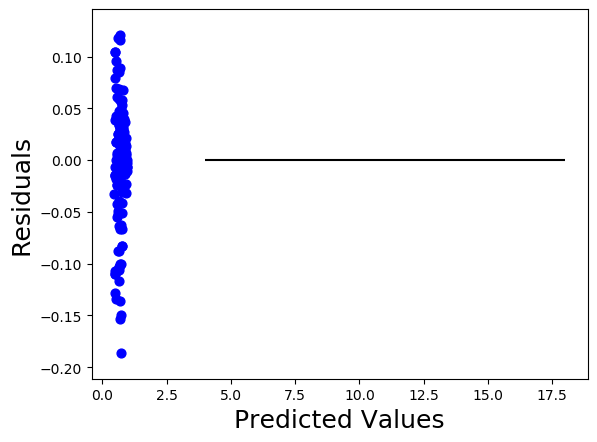

In [22]:
# Visualization: a residual plot to compare the model predictions and ground truth targets. For each example, the residual value
# is the subtraction between the prediction and ground truth target.
# We can see that the points in the residual plot are randomly dispersed around the horizontal axis y = 0,
# which indicates the fitted regression model is appropriate for the ABALONE data

residuals = ground_truth_label.values[:, 0] - model_predictions
plt.scatter(model_predictions, residuals, color="blue", s=40)
plt.hlines(y=0, xmin=4, xmax=18)
plt.xlabel("Predicted Values", fontsize=18)
plt.ylabel("Residuals", fontsize=18)
plt.show()

In [23]:
# Evaluate the model predictions quantitatively.
eval_r2_score = r2_score(ground_truth_label.values, model_predictions)
eval_mse_score = mean_squared_error(ground_truth_label.values, model_predictions)
eval_mae_score = mean_absolute_error(ground_truth_label.values, model_predictions)
print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{r2_score.__name__}{unbold}: {eval_r2_score}{newline}"
    f"{bold}{mean_squared_error.__name__}{unbold}: {eval_mse_score}{newline}"
    f"{bold}{mean_absolute_error.__name__}{unbold}: {eval_mae_score}{newline}"
)

Evaluation result on test data:
r2_score: 0.8347803463244985
mean_squared_error: 0.0032756969897500972
mean_absolute_error: 0.041440139984582014

